In [42]:
import Scribe as sc
from Scribe.Scribe import causal_net_dynamics_coupling as Scribe
import scanpy as sp
import numpy as np 
import os
import networkx as nx 
nx.__version__

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import dynamo as dyn 
import mygene
from anndata import AnnData
import copy
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.1.25 (python 3.7.6) on 2020-05-15 13:42.
 Your version: 		 0.1.25 
 Latest version: 	 0.2.0


In [2]:
wkdir = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/3_Scribe'
os.chdir(wkdir)

-----

<h1><font size="8"><center> 1. scVelo </center></font></h1>

## 1.0 Read velocyto loom file

In [3]:
wkdir = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_2_scVelo'
os.chdir(wkdir)

loom_file = "/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_2_Velocyto/Exp391.loom"
adata = scv.read(loom_file, cache=True)
adata.var_names_make_unique()

# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Abundance of ['spliced', 'unspliced', 'ambiguous']: [0.68 0.27 0.06]


AnnData object with n_obs × n_vars = 18353 × 22630 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## 1.1 Preliminary filtering & data merging

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000)
scv.pp.log1p(adata)

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=5000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 12269 genes that are detected in less than 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Filtered out 507 genes that are detected in less than 30 counts (shared).
Skip filtering by dispersion since number of variables are less than `n_top_genes`
computing neighbors
    finished (0:00:11) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


## 1.2 Add Scanpy-PAGA info

In [5]:
#####----- Read scanpy files
sc_obs_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/obs.csv'
sc_obsm_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/obsm.csv'
sc_count_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all_norm_counts_named_c10.csv'

sc_obs_tb = pd.read_csv(sc_obs_file)
sc_obsm_tb = pd.read_csv(sc_obsm_file)
sc_count_tb = pd.read_csv(sc_count_file)

# Merge fa to obs_tb
sc_obs_tb['fa1'] = sc_obsm_tb['X_draw_graph_fa1']
sc_obs_tb['fa2'] = sc_obsm_tb['X_draw_graph_fa2']

# Unifying format of cell id & 
sc_cell_id = list(sc_obs_tb.iloc[:,0])
sc_cell_id = [x.replace("-1", "") for x in sc_cell_id]
sc_obs_tb.columns = ["cell_id"] +  list(sc_obs_tb.columns)[1:] # change column names
sc_obs_tb['cell_id'] = sc_cell_id # Use unified format for Cell ID

sc_gene_name = list(sc_count_tb.columns)[1:]

#####----- Cell filtering and gene filtering based on scanpy analysis
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
scv_gene_name = list(adata.var.index)
scv_cell_use = ["Use" if x in sc_cell_id else "No" for x in scv_cell_id]
adata.obs['scanpy_paga'] = scv_cell_use

adata = adata[adata.obs['scanpy_paga'] == 'Use', :]

#####----- Use same cell id order for obs_tb and vlm object
scv_cell_id = [x.replace("Exp391:", "").replace("x", "") for x in adata.obs.index]
sc_cell_id = list(sc_obs_tb['cell_id'])

sc_cell_id_newidx = [sc_cell_id.index(x) for x in scv_cell_id]
sc_obs_tb = sc_obs_tb.reindex(sc_cell_id_newidx)


#####----- Add FA
sc_fa = pd.DataFrame({'fa1': sc_obs_tb['fa1'], 'fa2': sc_obs_tb['fa2']})
adata.obsm = {'fa': sc_fa.to_numpy()}

#####----- Add obs from scanpy-paga
adata.obs['cell_type'] = list(sc_obs_tb['cell_type'])
adata.obs['louvain'] = list(sc_obs_tb['louvain'])

In [18]:
newlabel_info = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/z_Info/Exp391_newLabels.csv'
newlabel_tb = pd.read_csv(newlabel_info)
new_labels = list(newlabel_tb['new_label'])
old_labels = list(newlabel_tb['old_label'])
adata.obs['louvain_newlabel'] = [new_labels[old_labels.index("L%s"%str(x))] for x in adata.obs['louvain'].values]

## 1.3 Run scVelo

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:02) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


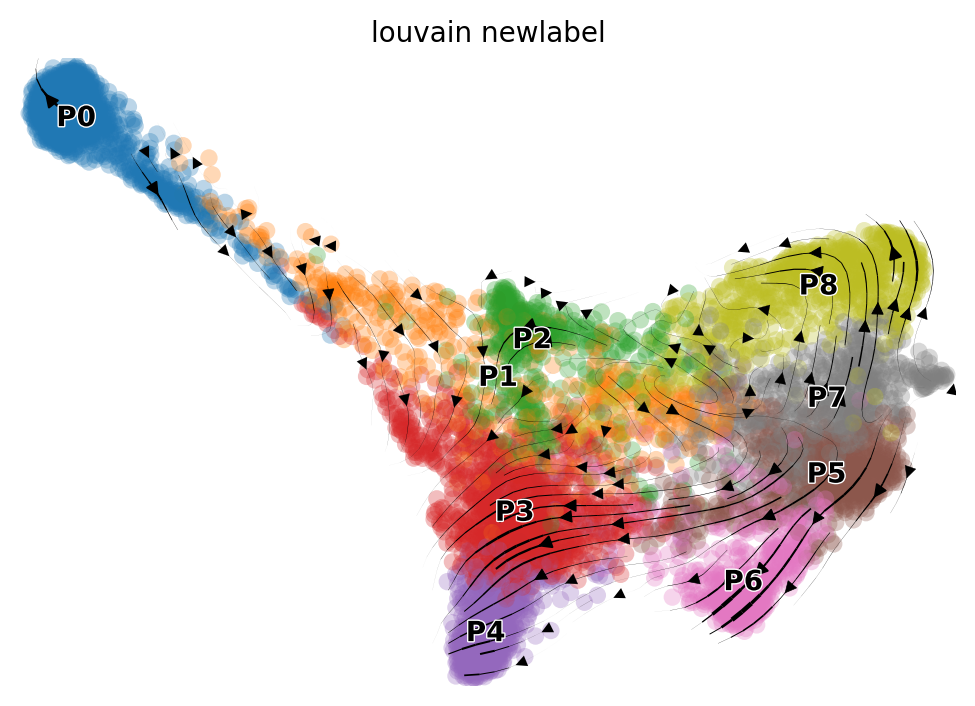

In [20]:
scv.pl.velocity_embedding_stream(adata, basis='fa', color=['louvain_newlabel'], dpi=100)

<h1><font size="8", color="3399ff"><center> 2. Scribe for sepearate clusters </center></font></h1>

In [14]:
adata_use = copy.copy(adata)

In [38]:
use_types = ['P0', 'P1']
adata_use = adata_use[[True if x in use_types else False for x in adata_use.obs['louvain_newlabel'].values]]

In [43]:
time.time()

1589564559.043224

array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


100
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


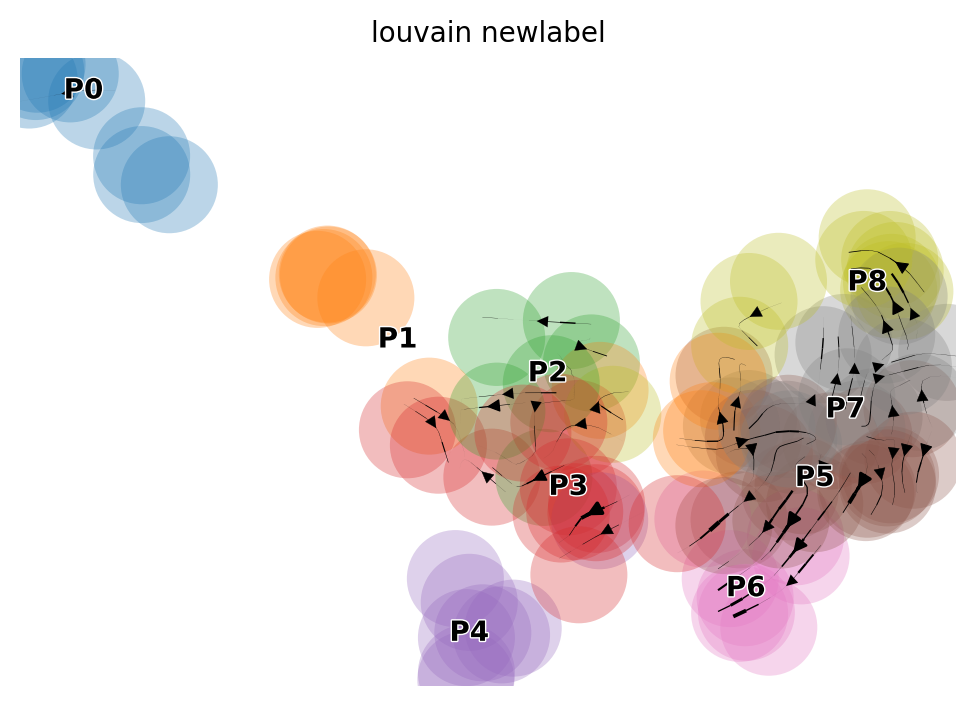

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


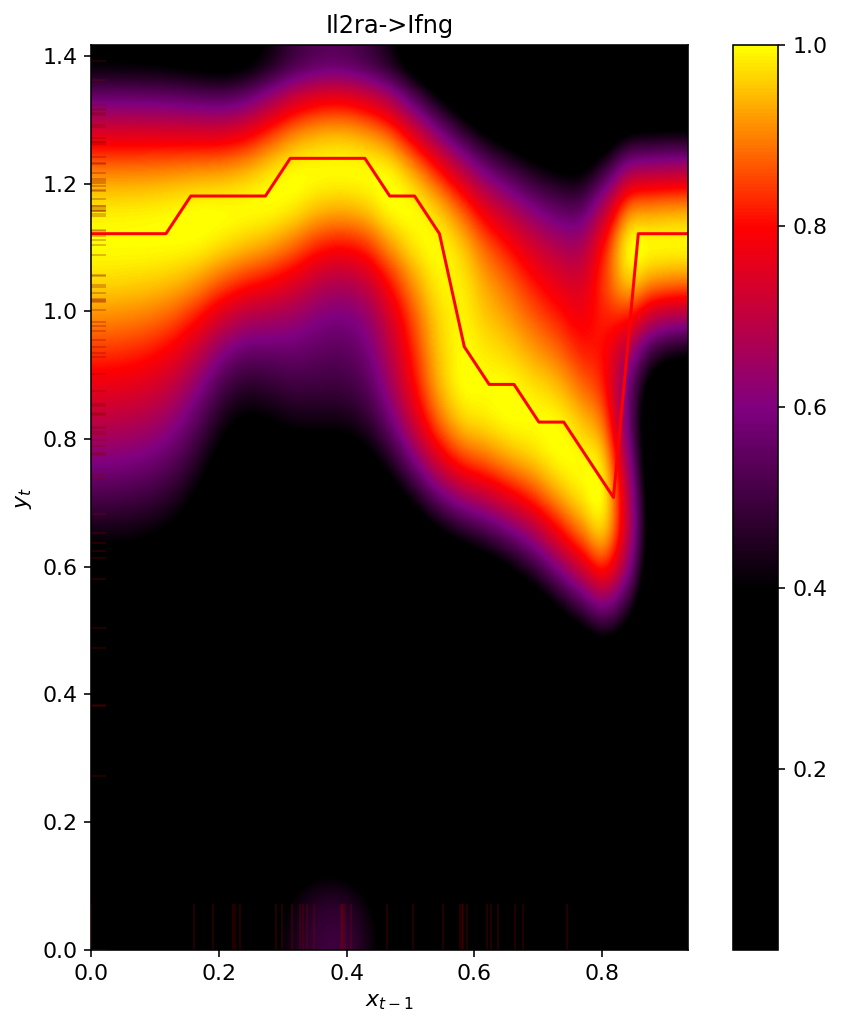

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


200
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


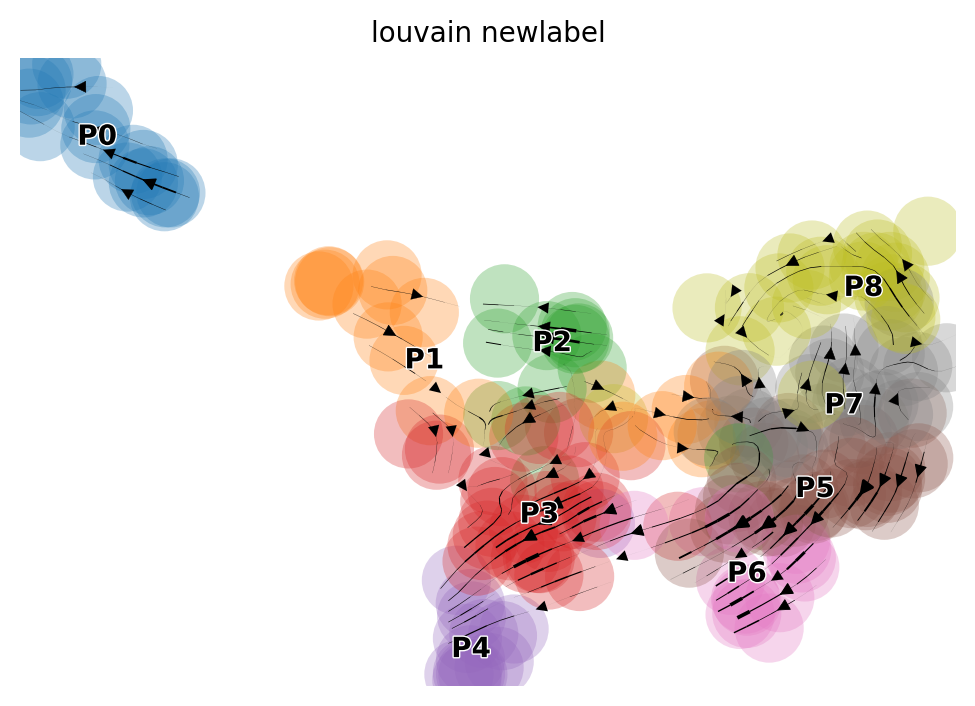

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


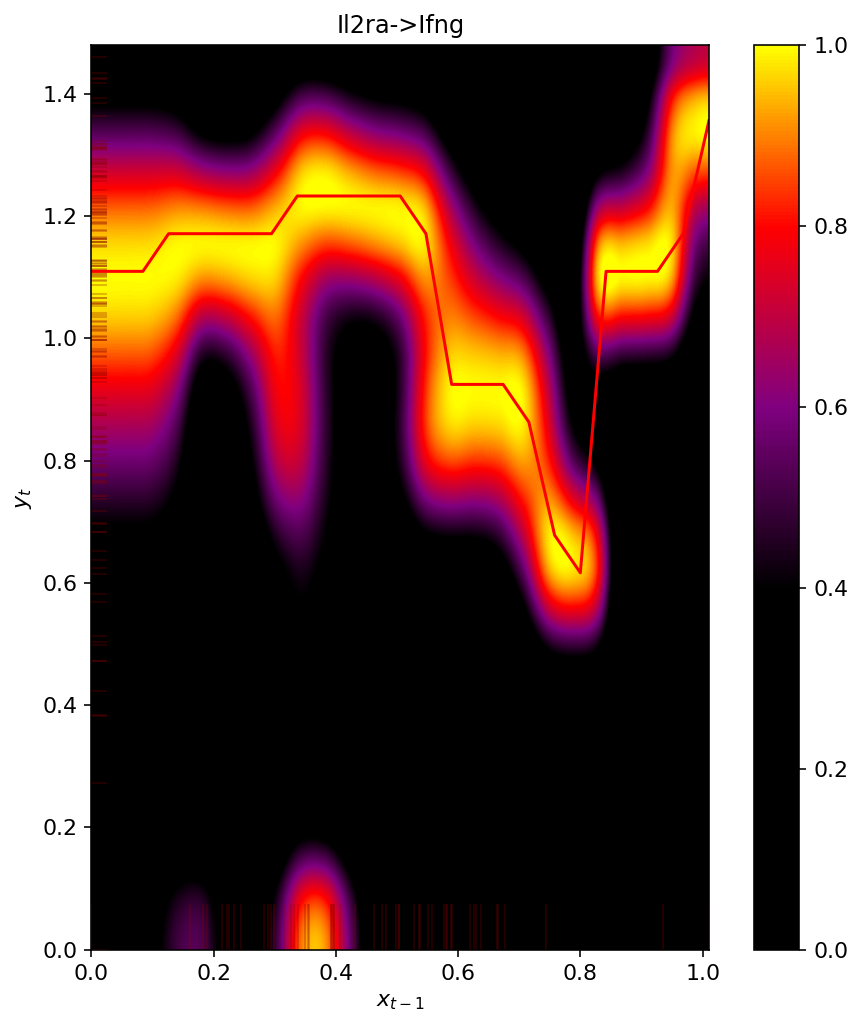

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


300
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


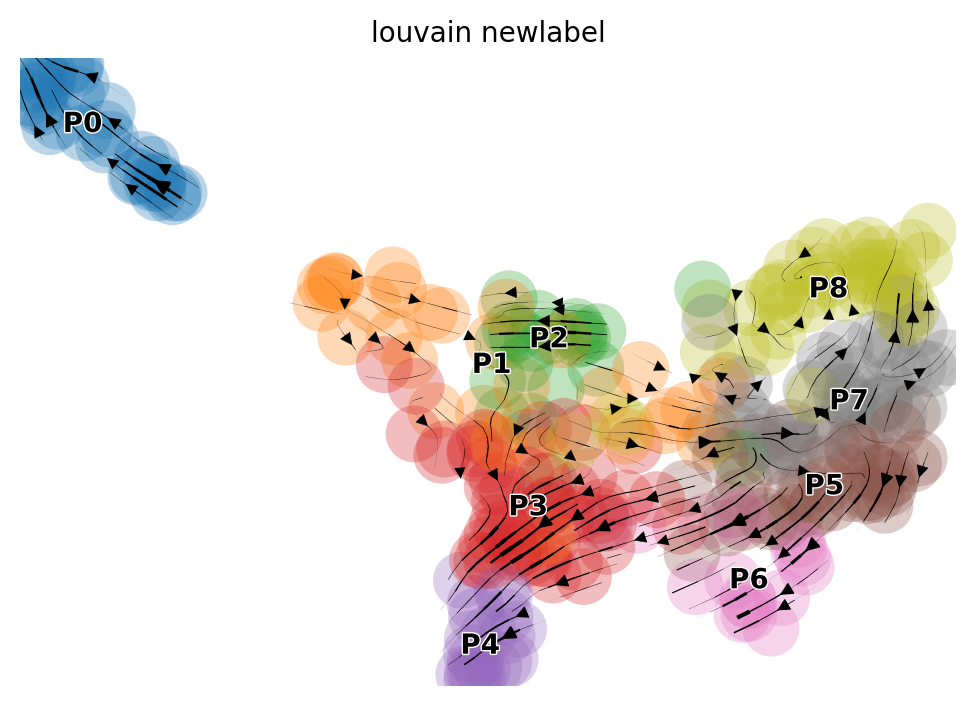

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


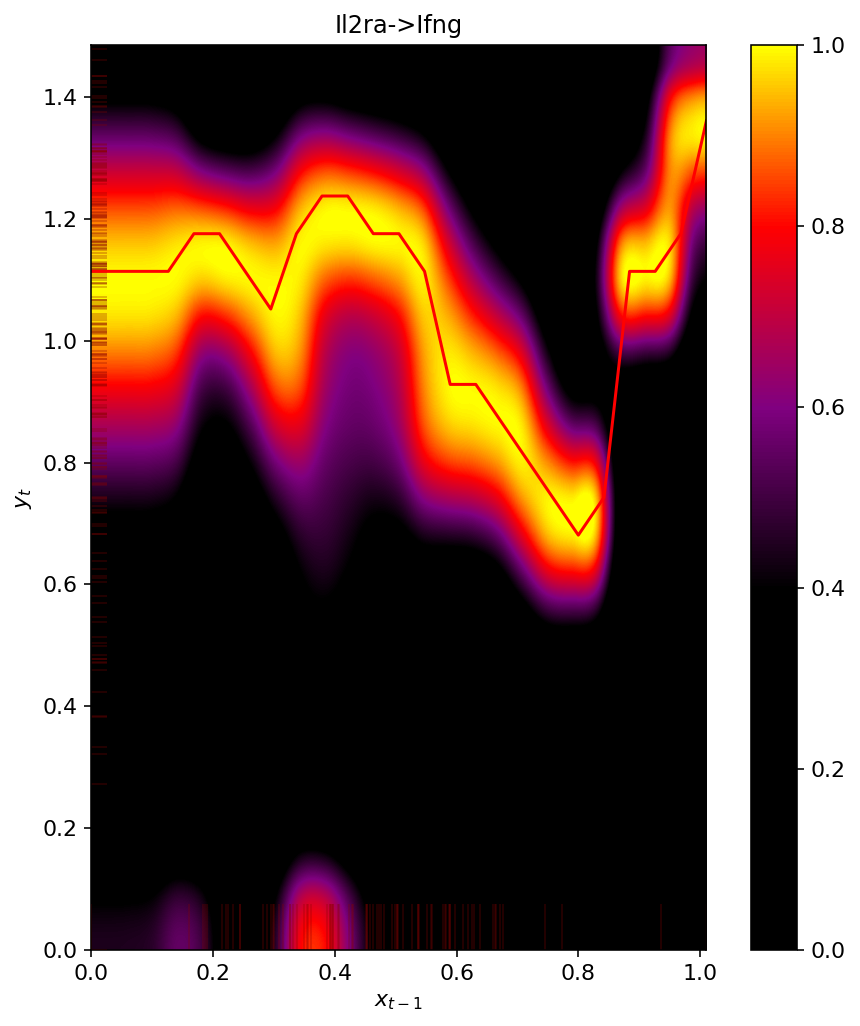

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


400
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


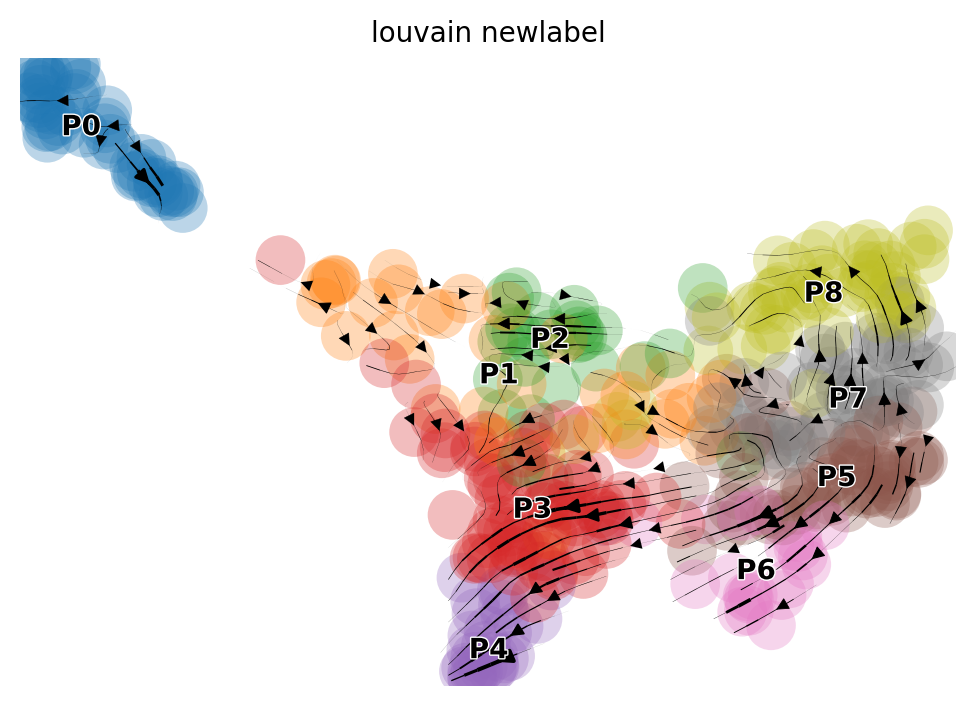

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


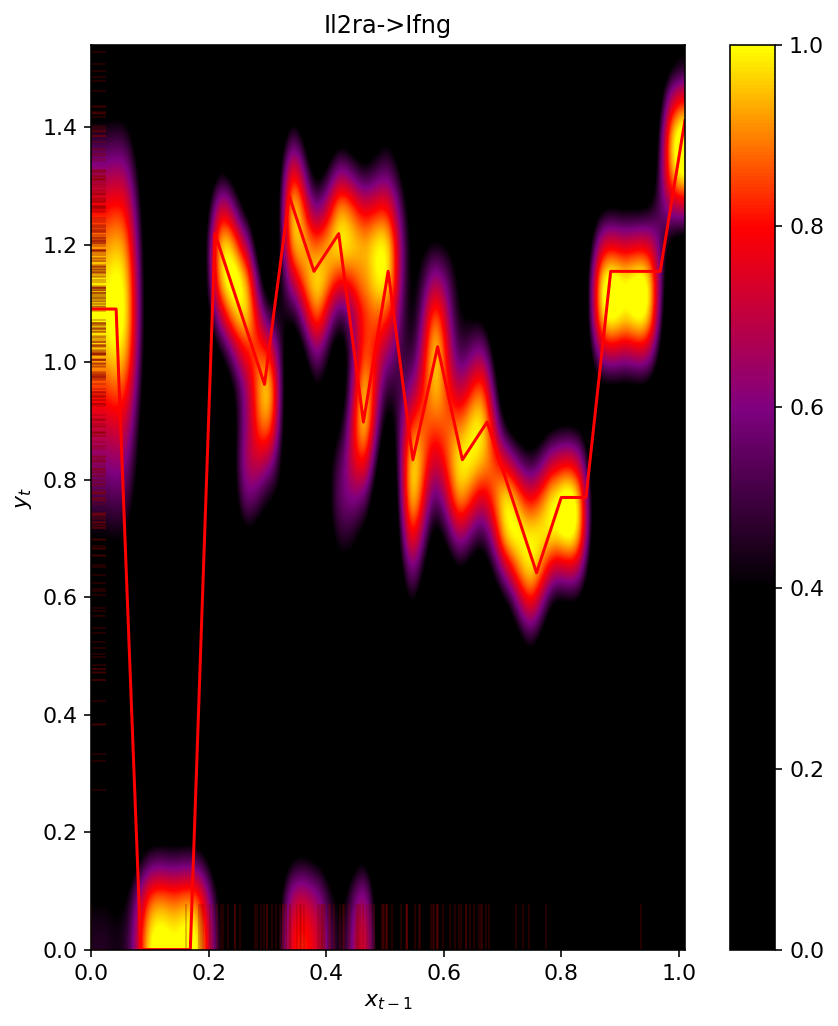

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


500
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


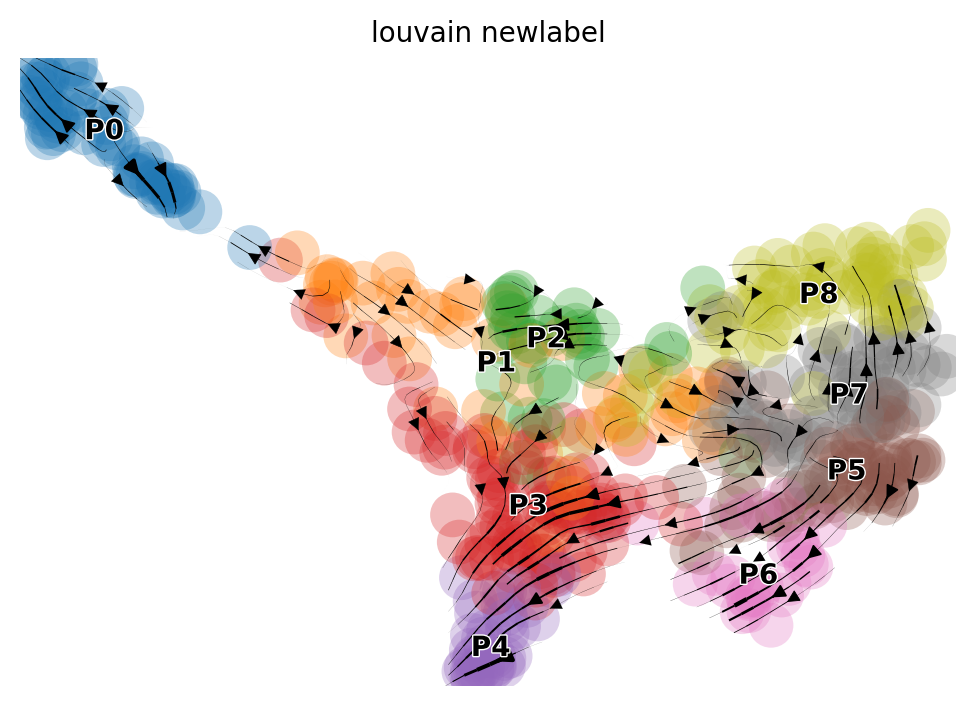

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


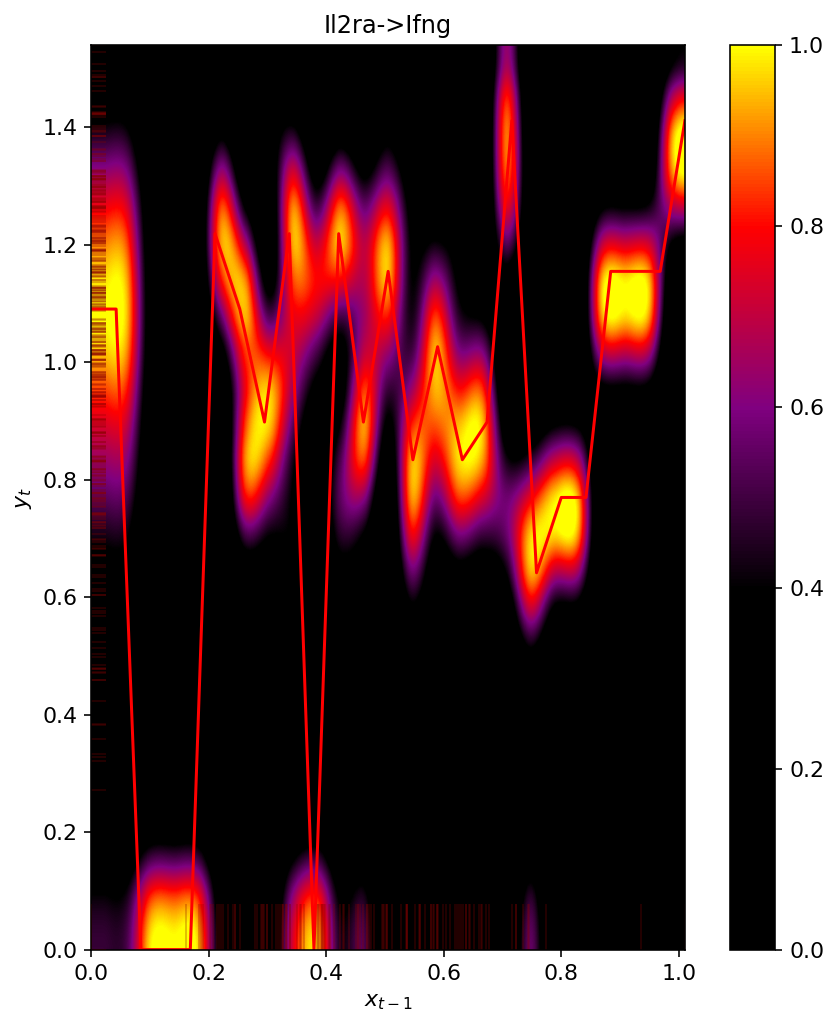

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


600
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


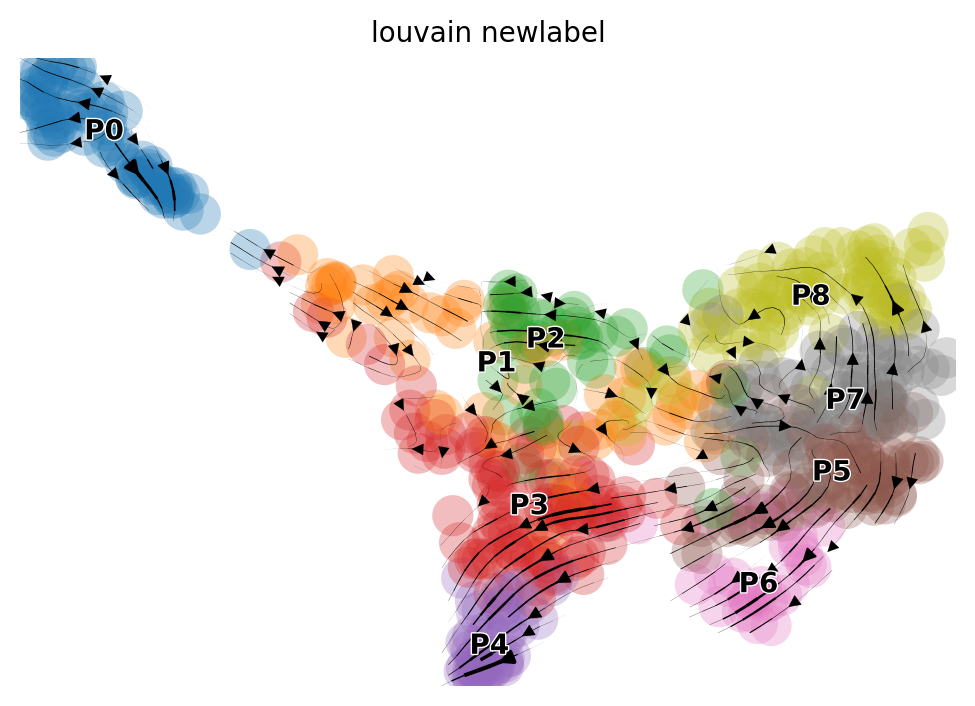

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


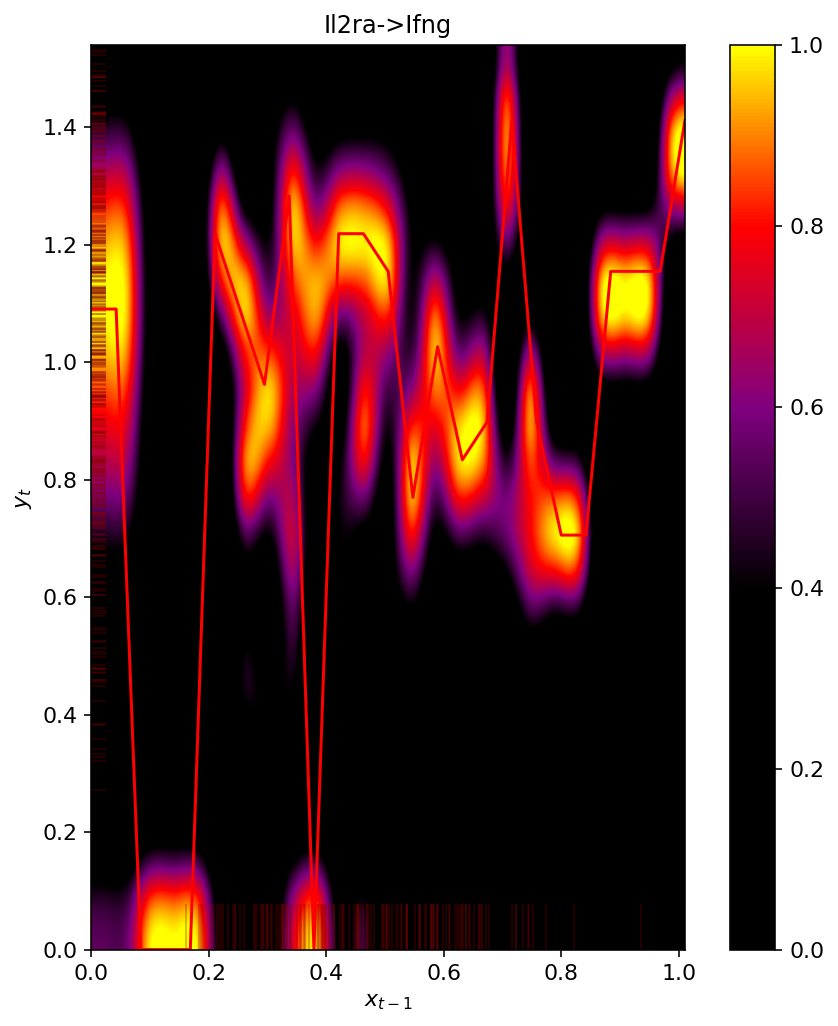

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


700
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


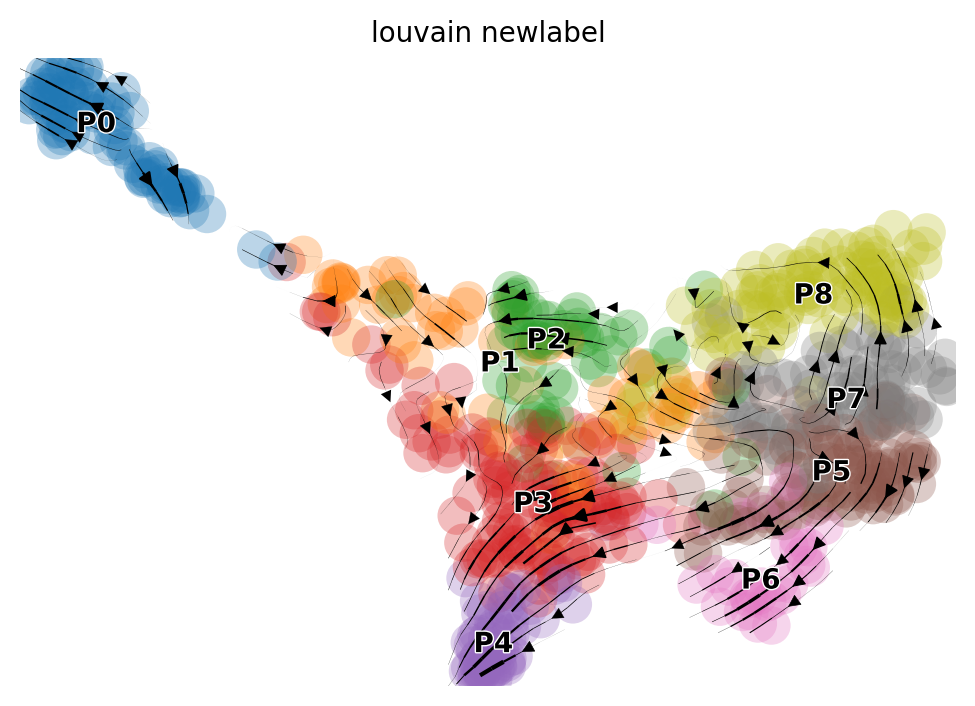

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


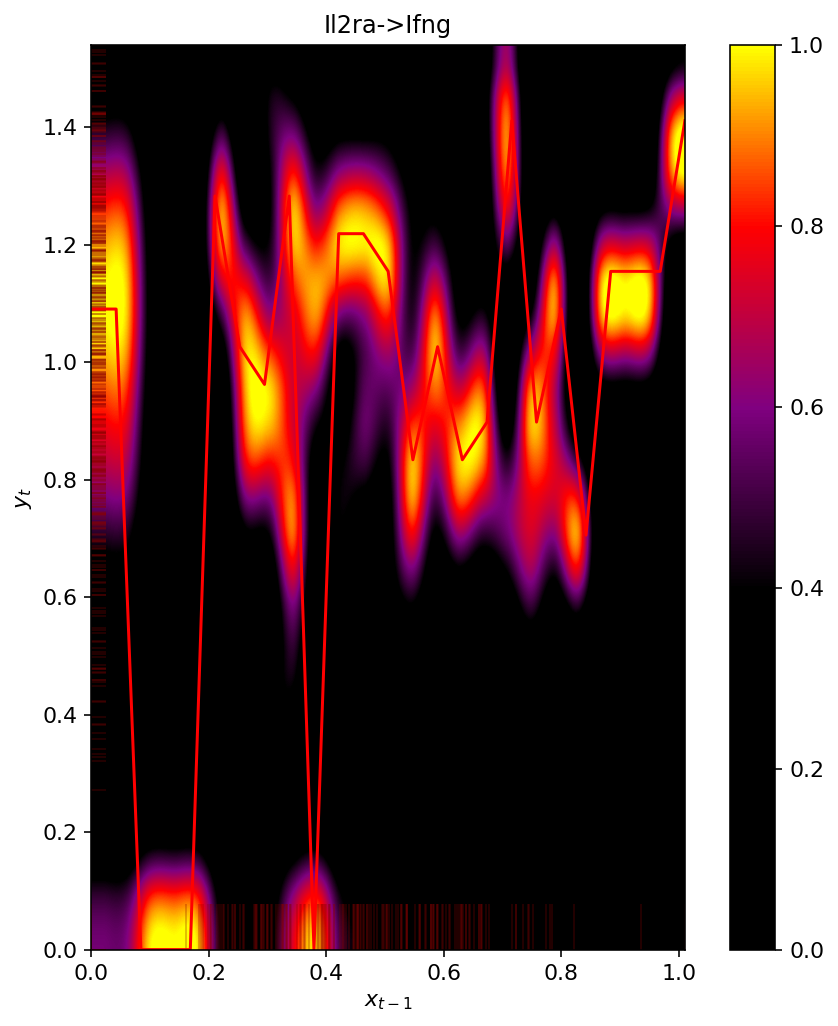

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


800
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


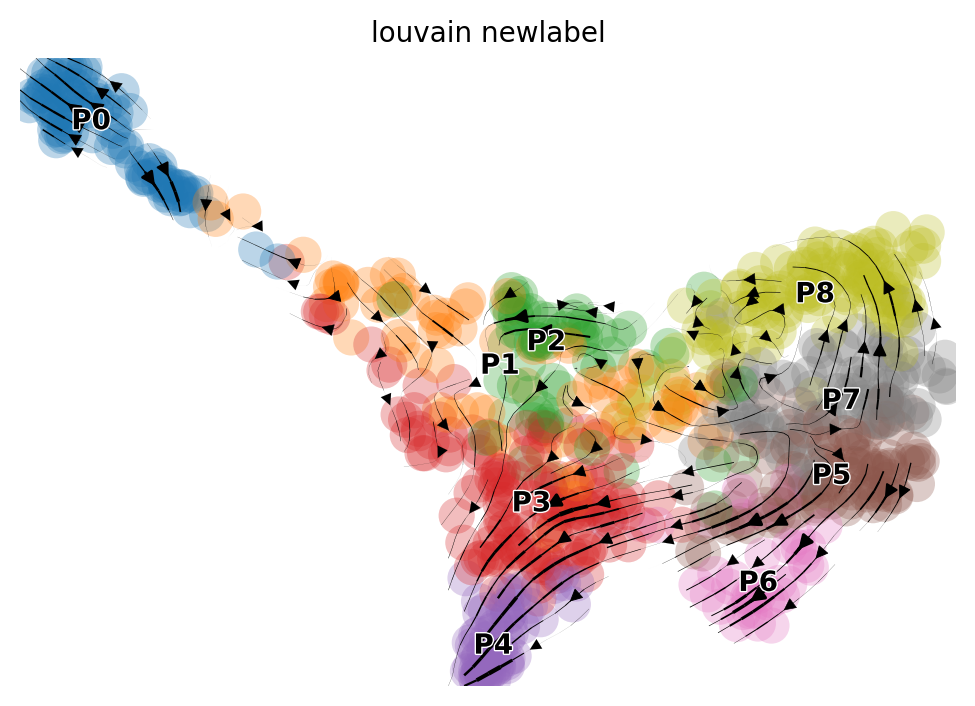

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


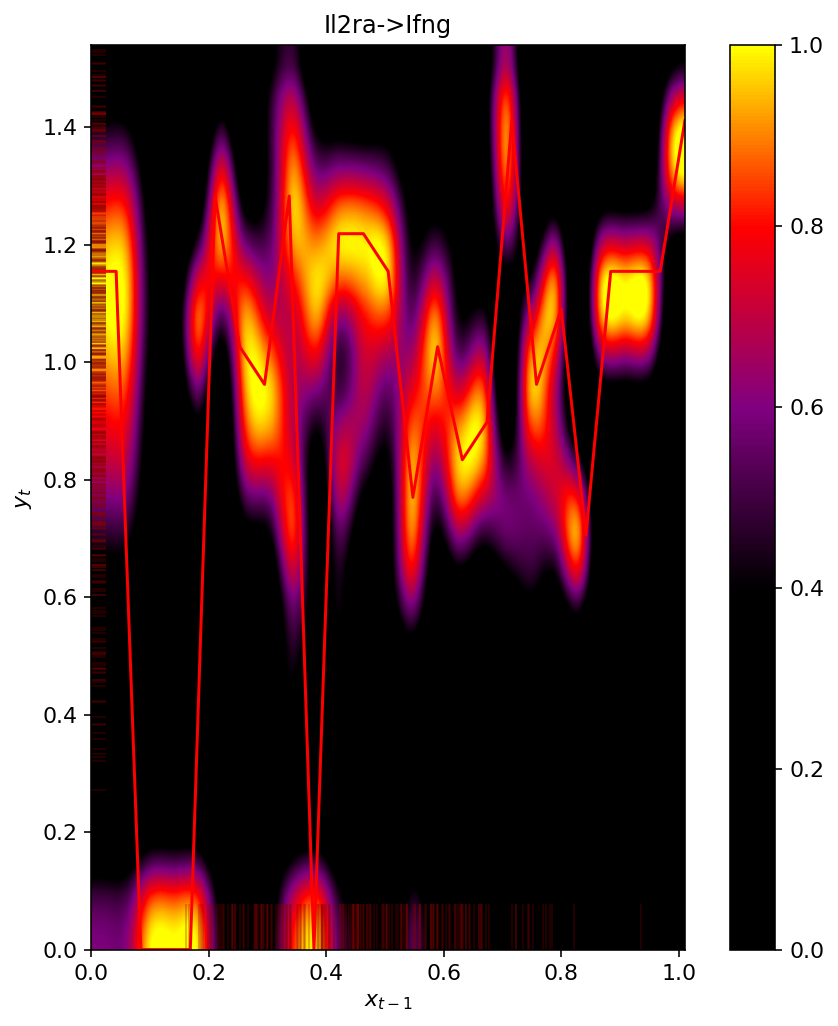

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


900
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


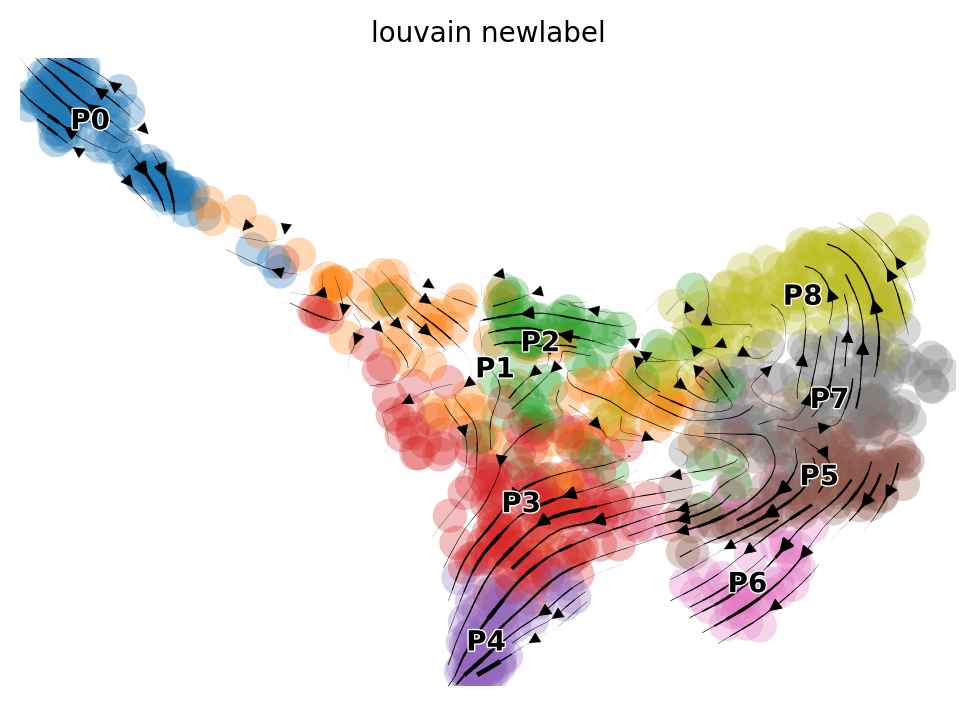

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


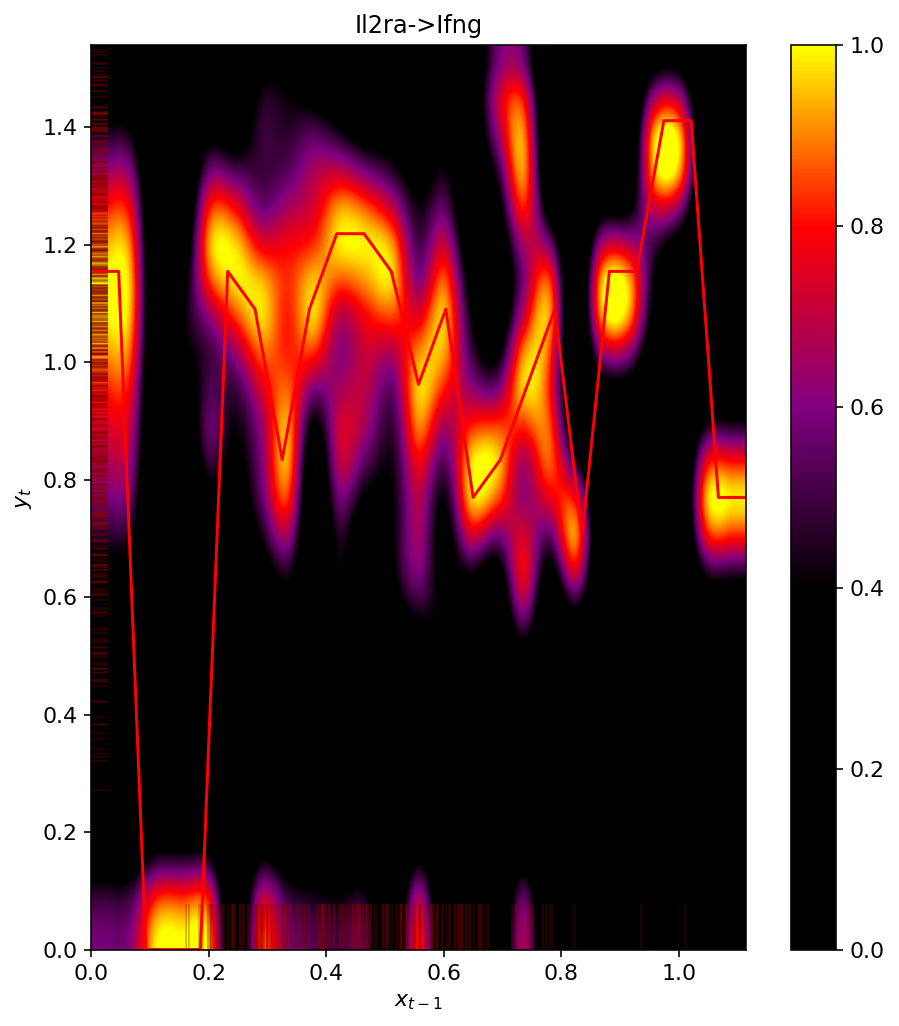

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


1000
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:00) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing velocity graph
    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa', embedded velocity vectors (adata.obsm)


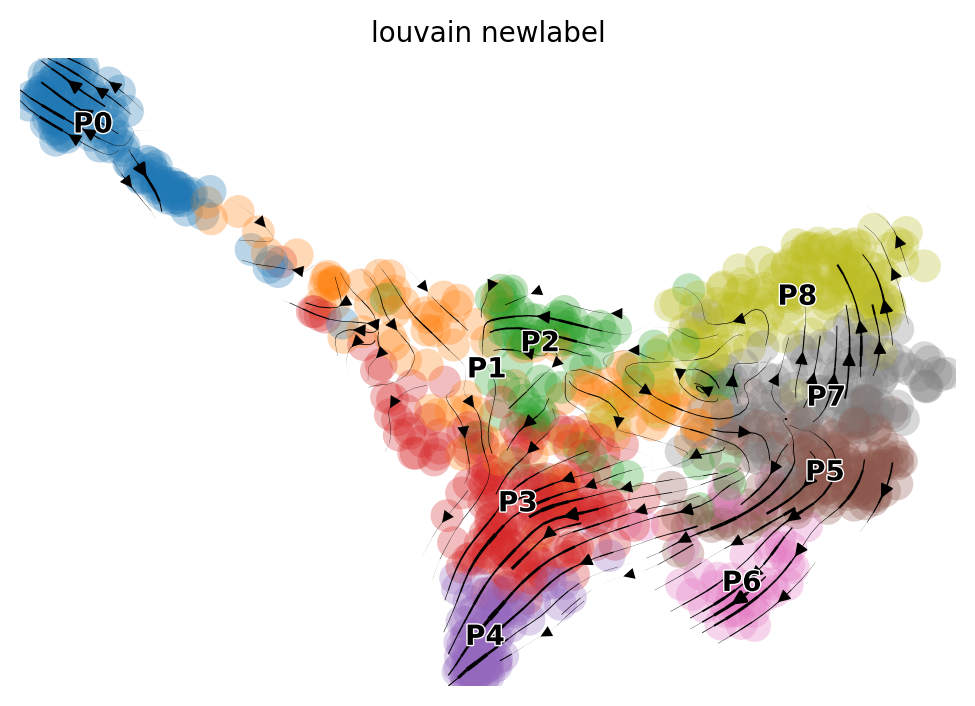

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


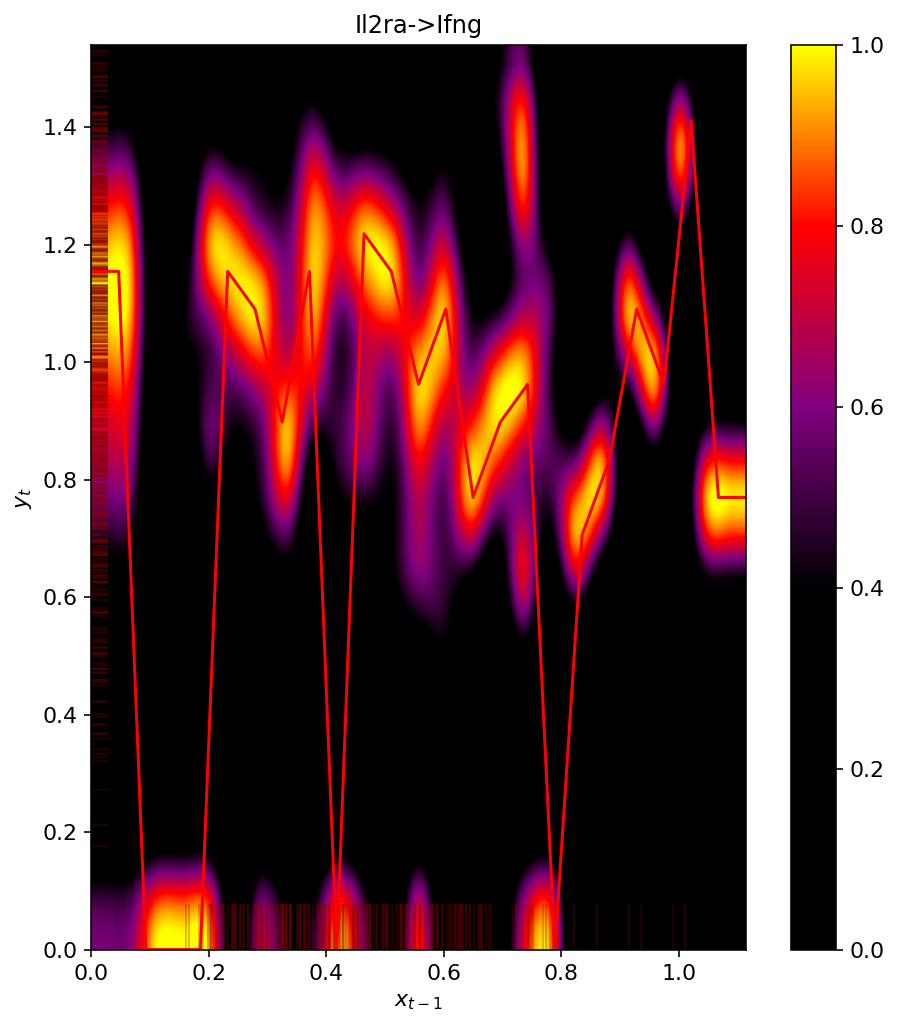

In [66]:
use_n_list = np.linspace(100, 1000, 10).astype(int)
time_df = pd.DataFrame({"use_cell_number": use_n_list})

use_time = []
for use_n in use_n_list:
    print(use_n)
    adata_use = copy.copy(adata)
    adata_use = adata_use[np.concatenate((np.repeat(True, use_n), np.repeat(False, (len(adata.obs)) - use_n)), axis=0)]

    scv.tl.velocity(adata_use)
    scv.tl.velocity_graph(adata_use)
    scv.pl.velocity_embedding_stream(adata_use, basis='fa', color=['louvain_newlabel'], dpi=100)

    time_pre = time.time()
    sc.pl.viz_response(adata_use, np.array([['Il2ra','Ifng']]),grid_num=25, log=True)
    time_post = time.time()
    use_time.append(time_post - time_pre)
time_df['use_time'] = use_time

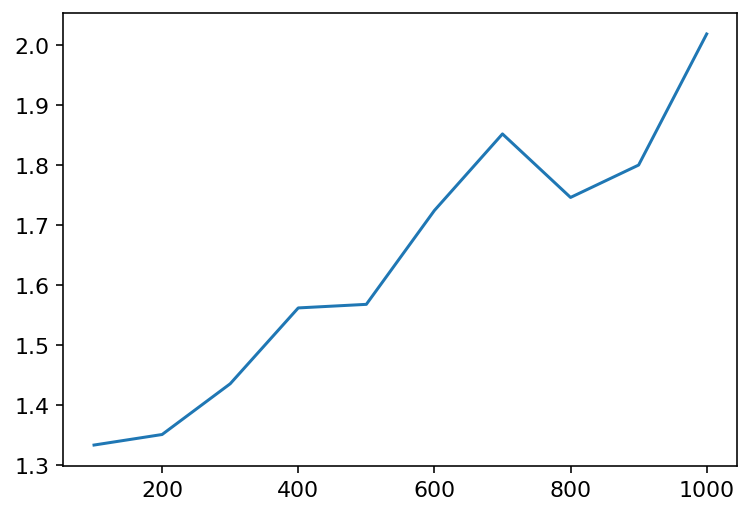

In [70]:
plt.plot(time_df['use_cell_number'], time_df['use_time'])

## Complexity O(n)

In [99]:
use_n_list = np.linspace(100, 2000, 20).astype(int)
scribe_time_df = pd.DataFrame({"use_cell_number": use_n_list})
cd8_regulators = ['Il2ra', 'Irf4', 'Ifng', 'Runx3', 'Tox', 'Tcf7', 'Cd44', 'Bcl6']

adata_use = copy.copy(adata)
scv.tl.velocity(adata_use)
scv.tl.velocity_graph(adata_use)

use_time = []
for use_n in use_n_list:
    print(use_n)
    adata_use_n = copy.copy(adata_use)
    adata_use_n = adata_use_n[np.concatenate((np.repeat(True, use_n), np.repeat(False, (len(adata.obs)) - use_n)), axis=0)]
    adata_use_n = adata_use_n[:,cd8_regulators]

    time_pre = time.time()
    Scribe(adata_use_n, t0_key='spliced', t1_key='unspliced')
    time_post = time.time()
    use_time.append(time_post - time_pre)
scribe_time_df['use_time'] = use_time

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
100


Trying to set attribute `.uns` of view, copying.


200


Trying to set attribute `.uns` of view, copying.


300


Trying to set attribute `.uns` of view, copying.


400


Trying to set attribute `.uns` of view, copying.


500


Trying to set attribute `.uns` of view, copying.


600


Trying to set attribute `.uns` of view, copying.


700


Trying to set attribute `.uns` of view, copying.


800


Trying to set attribute `.uns` of view, copying.


900


Trying to set attribute `.uns` of view, copying.


1000


Trying to set attribute `.uns` of view, copying.


1100


Trying to set attribute `.uns` of view, copying.


1200


Trying to set attribute `.uns` of view, copying.


1300


Trying to set attribute `.uns` of view, copying.


1400


Trying to set attribute `.uns` of view, copying.


1500


Trying to set attribute `.uns` of view, copying.


1600


Trying to set attribute `.uns` of view, copying.


1700


Trying to set attribute `.uns` of view, copying.


1800


Trying to set attribute `.uns` of view, copying.


1900


Trying to set attribute `.uns` of view, copying.


2000


Trying to set attribute `.uns` of view, copying.


In [100]:
scribe_time_df

use_cell_number    use_time
0               100    1.442088
1               200    3.396900
2               300    5.977651
3               400   10.475657
4               500   13.177727
5               600   17.975660
6               700   23.947217
7               800   30.946972
8               900   38.359338
9              1000   48.401646
10             1100   58.961121
11             1200   69.339707
12             1300   87.901645
13             1400  107.977529
14             1500  118.348672
15             1600  144.844962
16             1700  137.942620
17             1800  185.709859
18             1900  196.313542
19             2000  235.565682

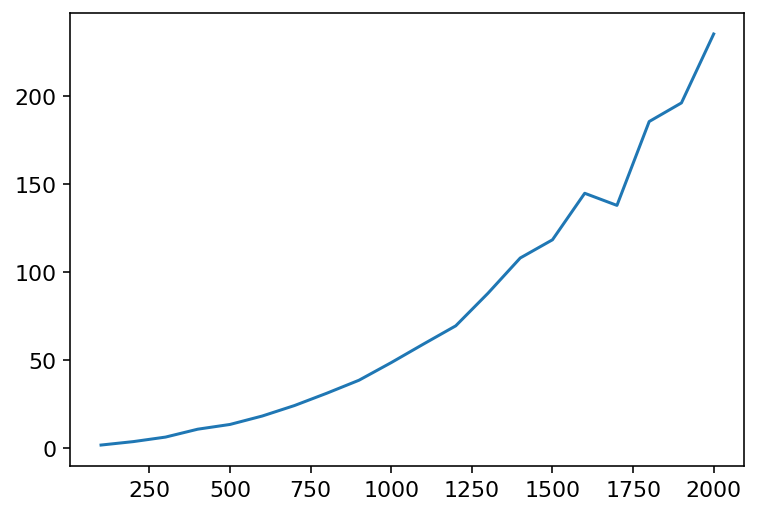

In [101]:
plt.plot(scribe_time_df['use_cell_number'], scribe_time_df['use_time'])

### Complexity on input cell number: > O(n<sup>2</sup>)

In [88]:
use_n_list = np.linspace(100, 1000, 10).astype(int)
cd8_regulators = ['Il2ra', 'Irf4', 'Ifng', 'Runx3', 'Tox', 'Tcf7', 'Cd44', 'Bcl6', 'Tbx21', 'Fos', 
                 'Slamf6', 'Sell', 'Klrg1', 'Ifng', 'Pdcd1', 'Prf1', 'Cx3cr1', 'Cd27', 'Cd103', 'Jun']
net_size = [6,8,10,12,14,16,18,20]

scribe_time_heatmap_df = pd.DataFrame({"use_cell_number": use_n_list})

adata_use = copy.copy(adata)
scv.tl.velocity(adata_use)
scv.tl.velocity_graph(adata_use)   

for i in net_size:
    print("------------------------------")
    print("------------------------------")
    print(i)
    
    i_time = []
    for use_n in use_n_list:
        print("----------")
        print(use_n)
        
        adata_use_i_n = copy.copy(adata_use)
        adata_use_i_n = adata_use_i_n[np.concatenate((np.repeat(True, use_n), np.repeat(False, (len(adata.obs)) - use_n)), axis=0)]

        adata_use_i_n = adata_use_i_n[:,cd8_regulators[:i]]

   

        time_pre = time.time()
        Scribe(adata_use_i_n, t0_key='spliced', t1_key='unspliced')
        time_post = time.time()
        i_time.append(time_post - time_pre)
    scribe_time_heatmap_df["net_size_%s"%str(i)] = i_time

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:31) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
------------------------------
------------------------------
6
----------
100


Trying to set attribute `.uns` of view, copying.


----------
200


Trying to set attribute `.uns` of view, copying.


----------
300


Trying to set attribute `.uns` of view, copying.


----------
400


Trying to set attribute `.uns` of view, copying.


----------
500


Trying to set attribute `.uns` of view, copying.


----------
600


Trying to set attribute `.uns` of view, copying.


----------
700


Trying to set attribute `.uns` of view, copying.


----------
800


Trying to set attribute `.uns` of view, copying.


----------
900


Trying to set attribute `.uns` of view, copying.


----------
1000


Trying to set attribute `.uns` of view, copying.


------------------------------
------------------------------
8
----------
100


Trying to set attribute `.uns` of view, copying.


----------
200


Trying to set attribute `.uns` of view, copying.


----------
300


Trying to set attribute `.uns` of view, copying.


----------
400


Trying to set attribute `.uns` of view, copying.


----------
500


Trying to set attribute `.uns` of view, copying.


----------
600


Trying to set attribute `.uns` of view, copying.


----------
700


Trying to set attribute `.uns` of view, copying.


----------
800


Trying to set attribute `.uns` of view, copying.


----------
900


Trying to set attribute `.uns` of view, copying.


----------
1000


Trying to set attribute `.uns` of view, copying.


------------------------------
------------------------------
10
----------
100


Trying to set attribute `.uns` of view, copying.


----------
200


Trying to set attribute `.uns` of view, copying.


----------
300


Trying to set attribute `.uns` of view, copying.


----------
400


Trying to set attribute `.uns` of view, copying.


----------
500


Trying to set attribute `.uns` of view, copying.


----------
600


Trying to set attribute `.uns` of view, copying.


----------
700


Trying to set attribute `.uns` of view, copying.


----------
800


Trying to set attribute `.uns` of view, copying.


----------
900


Trying to set attribute `.uns` of view, copying.


----------
1000


Trying to set attribute `.uns` of view, copying.


------------------------------
------------------------------
12
----------
100


Trying to set attribute `.uns` of view, copying.


----------
200


Trying to set attribute `.uns` of view, copying.


----------
300


Trying to set attribute `.uns` of view, copying.


----------
400


Trying to set attribute `.uns` of view, copying.


----------
500


Trying to set attribute `.uns` of view, copying.


----------
600


Trying to set attribute `.uns` of view, copying.


----------
700


Trying to set attribute `.uns` of view, copying.


----------
800


Trying to set attribute `.uns` of view, copying.


----------
900


Trying to set attribute `.uns` of view, copying.


----------
1000


Trying to set attribute `.uns` of view, copying.


------------------------------
------------------------------
14
----------
100


AttributeError: 'DataFrame' object has no attribute 'tolist'

In [89]:
scribe_time_heatmap_df

use_cell_number  net_size_6  net_size_8  net_size_10  net_size_12
0              100    0.781342    1.463797     2.336202     3.445044
1              200    1.763863    3.315637     5.462611     7.907337
2              300    3.262302    5.921768     9.306482    14.076087
3              400    5.209580   10.072524    15.669302    23.552660
4              500    6.895975   13.239890    19.578365    31.061395
5              600    9.269123   17.969209    27.613709    42.652175
6              700   13.145799   23.325570    35.798081    57.265430
7              800   16.204678   30.798113    46.590416    75.309074
8              900   20.889854   37.591319    60.408261    94.454794
9             1000   23.648477   48.135669    73.180442   117.959734

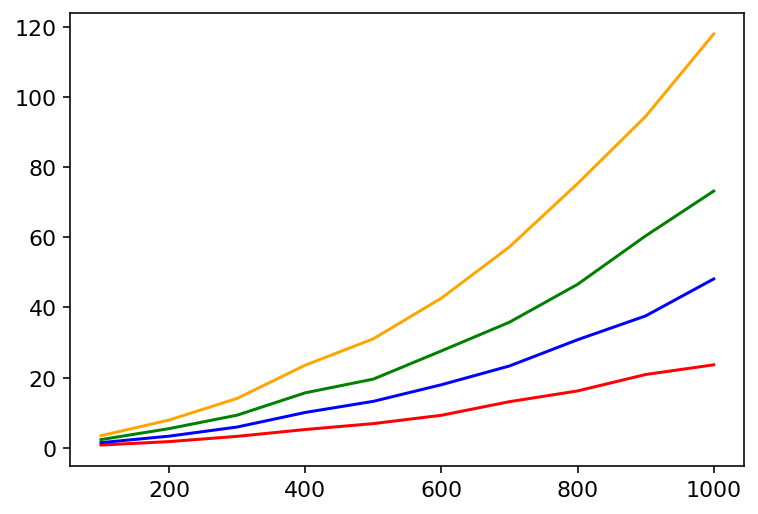

In [96]:
plt.plot(scribe_time_heatmap_df['use_cell_number'], scribe_time_heatmap_df['net_size_6'], color = "red", label = "net_size_6")
plt.plot(scribe_time_heatmap_df['use_cell_number'], scribe_time_heatmap_df['net_size_8'], color = "blue", label = "net_size_8")
plt.plot(scribe_time_heatmap_df['use_cell_number'], scribe_time_heatmap_df['net_size_10'], color = "green", label = "net_size_10")
plt.plot(scribe_time_heatmap_df['use_cell_number'], scribe_time_heatmap_df['net_size_12'], color = "orange", label = "net_size_12")
plt.show()

### Complexity on network size: > O(n<sup>2</sup>)

## Estimate for network of 2000 cells:
- 8 genes: 4 minutes
- 16 genes: 16 minutes
- 32 genes: 1h 4 minutes
- 64 genes: 2h 8 minutes

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix
f_ini_ind is  0   25


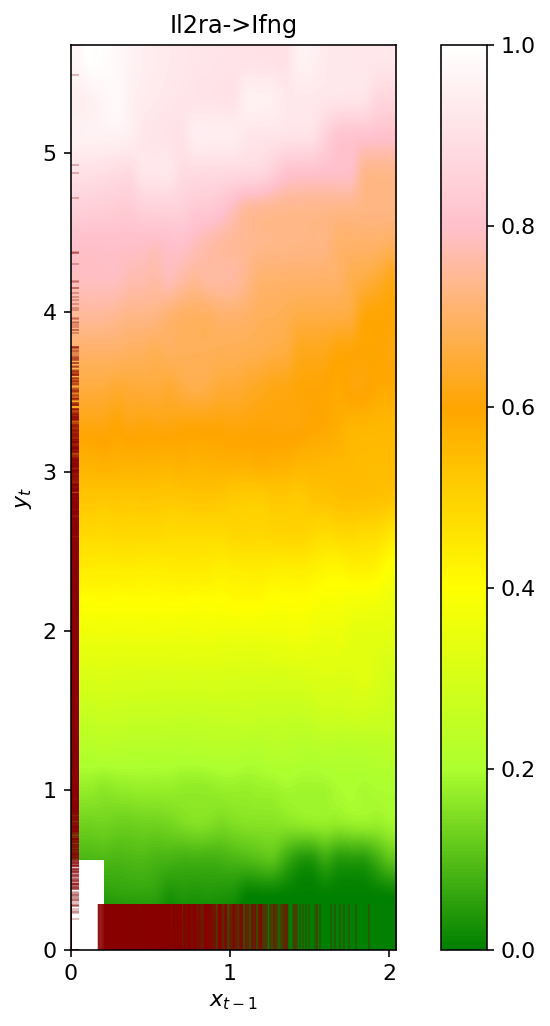

In [20]:
sc.pl.viz_causality(adata,np.array([['Il2ra','Ifng']]),grid_num=25, log=False)

Create causal_model successfully
<class 'scipy.sparse.csr.csr_matrix'> sparse matrix


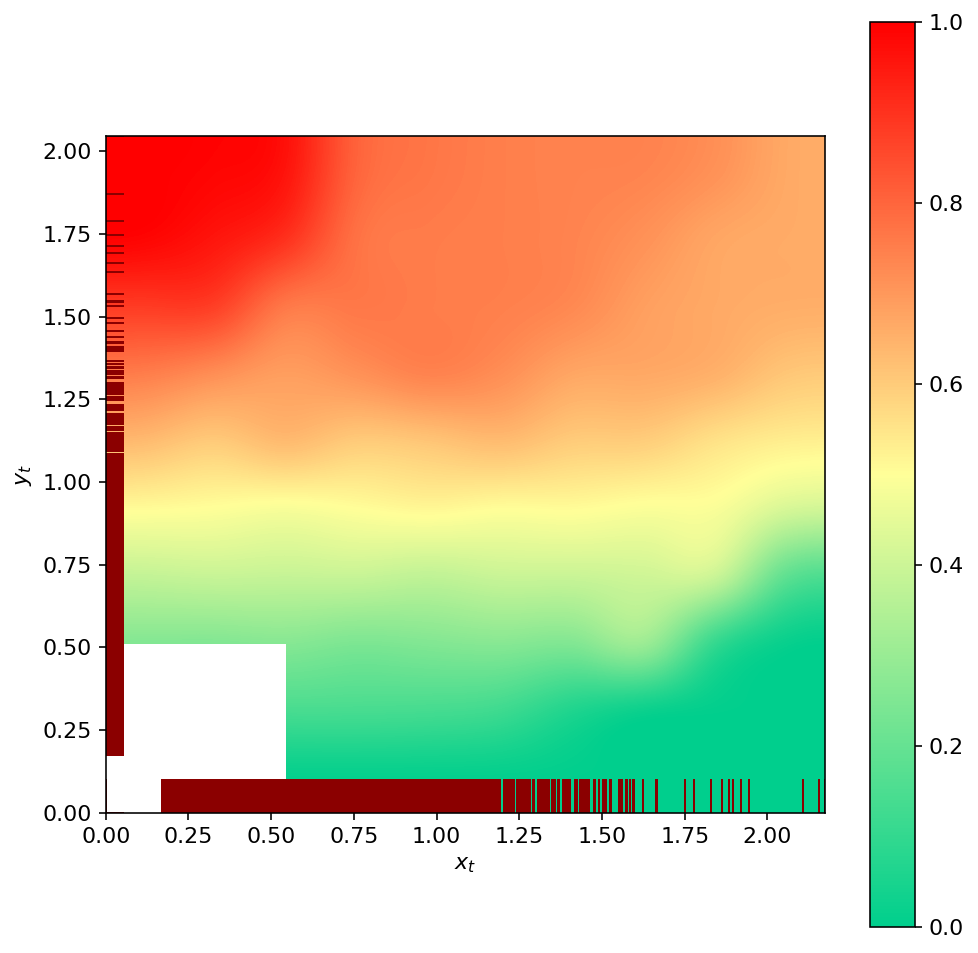

In [21]:
sc.pl.viz_comb_logic(adata,np.array([['Irf4','Il2ra', 'Ifng']]),grid_num=10, log=False)

### Select genes to use

In [246]:
###----- Find highly variable and highly expressed genes
highly_expr = list(adata.var[adata.var['means'] > 0.5].index.values)
paga_var_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/1_1_SCANPY_PAGA/all--numSlt-rmWTNAV/0_PAGA/all--numSlt-rmWTNAV/var.csv'
paga_var_tb = pd.read_csv(paga_var_file)
highly_variable = list(paga_var_tb.iloc[:,0].values)
highly_expr_or_variable = list(set(highly_expr + highly_variable))
velocity_genes = list(adata.var[adata.var['velocity_genes']].index)
highly_expr_or_variable_or_velocity = list(set(highly_expr_or_variable + velocity_genes))
len(highly_expr_or_variable_or_velocity)

3655

In [247]:
crf_all_file = 'https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv?token=AGIX2OZ4YV4SGOIZTLIGUUS6XH4OO'
crf_all_tb = pd.read_csv(crf_all_file)

tf_use_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/3_Scribe/use_TF_list.csv'
tf_use_tb = pd.read_csv(tf_use_file)

best_genes_file = '/media/pipkin/Yolanda/Exp391_Acute-Chronic_SC/z_References/Best_Goldrath_clusters/41590_2013_BFni2536_MOESM3_ESM.csv'
best_tb = pd.read_csv(best_genes_file)

In [248]:
tf_use = list(set(tf_use_tb['gene_name']) & set(highly_expr_or_variable))
crf_use = list(set(crf_all_tb['gene_name']) & set(highly_expr_or_variable))
tf_crf_use = list(set(tf_use + crf_use))

best_genes = list(best_tb.iloc[:,2])[1:]
best_genes = [x for x in best_genes if str(x) != 'nan']

tf_crf_best_genes = list(set(best_genes + tf_crf_use))

In [256]:
cd8_tf_crf_best_use = list(set(tf_crf_best_genes) & set(highly_expr_or_variable_or_velocity))
cd8_tf_crf_best_use = list(set(adata.var.index) & set(cd8_tf_crf_best_use))
len(cd8_tf_crf_best_use)

702

In [257]:
adata_cd8_subset = adata[:,cd8_tf_crf_best_use].copy()
adata_cd8_subset 

AnnData object with n_obs × n_vars = 6300 × 702 
    obs: 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'scanpy_paga', 'cell_type', 'louvain', 'velocity_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'pca', 'neighbors', 'velocity_settings', 'velocity_graph', 'velocity_graph_neg', 'louvain_colors'
    obsm: 'fa', 'X_pca', 'X_fa', 'velocity_fa'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'

In [ ]:
Scribe(adata_cd8_subset, t0_key='spliced', t1_key='unspliced')
adata_cd8_subset.uns['causal_net'].to_csv('causal_net.csv')

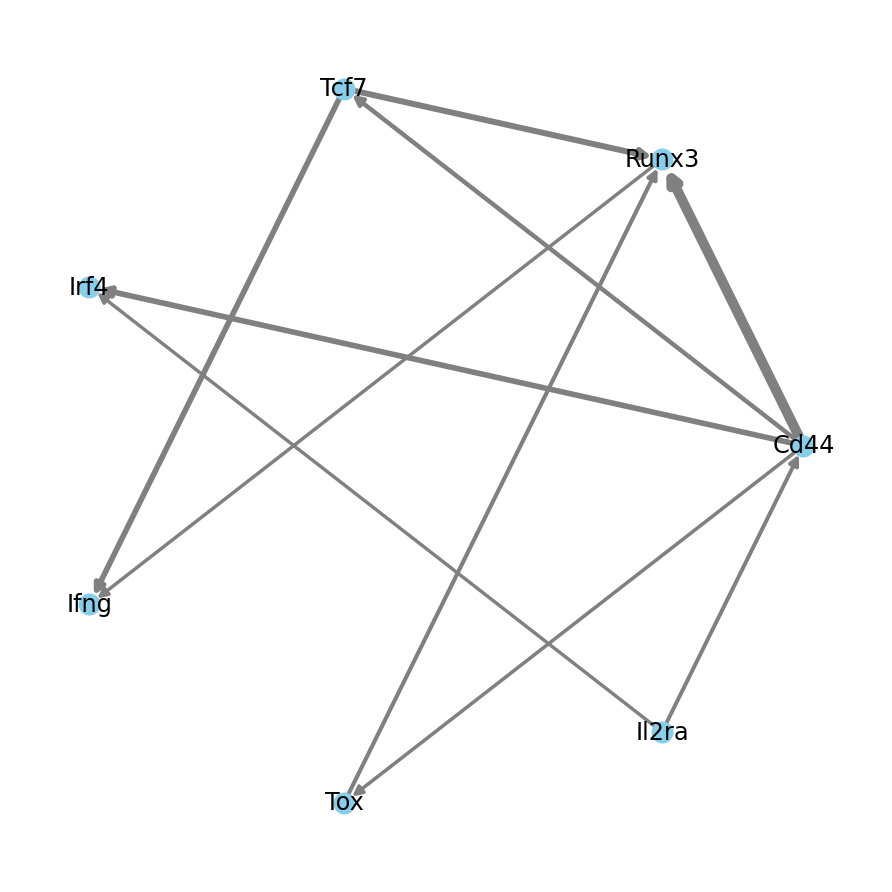

In [25]:
cd8_regulators = ['Il2ra', 'Irf4', 'Ifng', 'Runx3', 'Tox', 'Tcf7', 'Cd44', 'Bcl6']
adata_cd8_subset = adata[:,cd8_regulators].copy()
Scribe(adata_cd8_subset, t0_key='spliced', t1_key='unspliced')
sc.pl.vis_causal_net(adata_cd8_subset, figsize=[6, 6], layout='circular')

In [31]:
adata_cd8_subset.uns['causal_net']

Il2ra      Irf4      Ifng     Runx3       Tox      Tcf7      Cd44  \
Il2ra    NaN  0.066197  0.026642  0.034463  0.029585  0.035525  0.076371   
Irf4     NaN       NaN  0.040720       NaN  0.033412  0.028421       NaN   
Ifng     NaN       NaN       NaN       NaN  0.037998       NaN       NaN   
Runx3    NaN  0.056387  0.067042       NaN       NaN       NaN       NaN   
Tox      NaN       NaN       NaN  0.079943       NaN  0.048228       NaN   
Tcf7     NaN       NaN  0.108472  0.115987       NaN       NaN       NaN   
Cd44     NaN  0.109308  0.065987  0.194060  0.069002  0.086399       NaN   
Bcl6     NaN       NaN  0.002066  0.001408  0.001631       NaN  0.004278   

           Bcl6  
Il2ra  0.000899  
Irf4   0.000624  
Ifng        NaN  
Runx3       NaN  
Tox         NaN  
Tcf7   0.005238  
Cd44        NaN  
Bcl6        NaN

In [111]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  12
